In [1]:
!sudo chown -R jupyter:jupyter /home/jupyter/xray_analysis/

In [2]:
import os
import shutil
import datetime

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.layers import Dense, Flatten, Softmax

print(tf.__version__)

2.6.0-dev20210620


In [3]:
# to access data from dir using keras.preprocessing.image_dataset_from_directory
!python3 -m pip install --user tf-nightly

In [4]:
img_height, img_width = 180, 180
batch_size = 32
training_data_dir = '/home/jupyter/t3-chest-xray-uscentral/chest_xray/train'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    training_data_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)


Found 5217 files belonging to 2 classes.
Using 4174 files for training.


In [5]:
class_names = train_ds.class_names
print(class_names)

['NORMAL', 'PNEUMONIA']


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    training_data_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 5217 files belonging to 2 classes.
Using 1043 files for validation.


In [7]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [8]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.044043437 0.8585584


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [11]:
num_classes = 2
model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [12]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [15]:
logdir = os.path.join(
    "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=logdir, histogram_freq=1)

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=30,
  callbacks=[tensorboard_callback]
)

Epoch 1/30
131/131 [==============================] - 43s 325ms/step - loss: 1.3939e-04 - accuracy: 1.0000 - val_loss: 0.1451 - val_accuracy: 0.9827
Epoch 2/30
131/131 [==============================] - 42s 319ms/step - loss: 4.6210e-05 - accuracy: 1.0000 - val_loss: 0.1484 - val_accuracy: 0.9837
Epoch 3/30
131/131 [==============================] - 42s 321ms/step - loss: 3.4079e-05 - accuracy: 1.0000 - val_loss: 0.1514 - val_accuracy: 0.9837
Epoch 4/30
131/131 [==============================] - 42s 318ms/step - loss: 2.7210e-05 - accuracy: 1.0000 - val_loss: 0.1541 - val_accuracy: 0.9837
Epoch 5/30
131/131 [==============================] - 42s 318ms/step - loss: 2.2693e-05 - accuracy: 1.0000 - val_loss: 0.1565 - val_accuracy: 0.9837
Epoch 6/30
131/131 [==============================] - 42s 320ms/step - loss: 1.9431e-05 - accuracy: 1.0000 - val_loss: 0.1586 - val_accuracy: 0.9837
Epoch 7/30
131/131 [==============================] - 42s 318ms/step - loss: 1.6895e-05 - accuracy: 1.0000

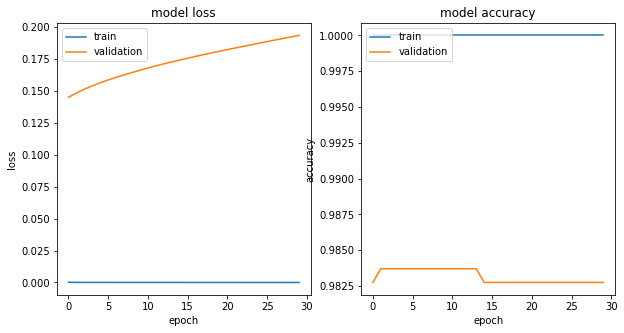

In [16]:
# Plot
import matplotlib.pyplot as plt
nrows = 1
ncols = 2
fig = plt.figure(figsize=(10, 5))

for idx, key in enumerate(["loss", "accuracy"]):
    ax = fig.add_subplot(nrows, ncols, idx+1)
    plt.plot(history.history[key])
    plt.plot(history.history["val_{}".format(key)])
    plt.title("model {}".format(key))
    plt.ylabel(key)
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left");

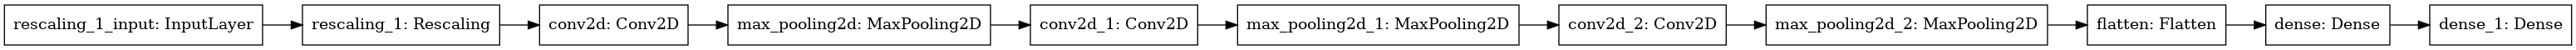

In [17]:
tf.keras.utils.plot_model(
    model=model, to_file="xray_model.png", show_shapes=False, rankdir="LR")

In [18]:
model.summary

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x7f4825c9c150>>